Mounted at /content/drive
Connecting to database: cfb_data.db
Loading necessary game data...
Loaded 9816 completed games.
Dropped 6578 rows missing scores or opening/closing spreads.
Analyzing 3238 games with complete data.
Determining CLV direction and simulating bets...
Found 3006 games with non-zero CLV to simulate.

--- CLV Betting Simulation Results ---
Total CLV Bets Placed: 3006
  Wins:           1608
  Losses:         1361
  Pushes:         37
  Win Rate:       54.16%
  Total Units:    +110.90
  Implied ROI:    3.40%

--- Win Rate vs. CLV Amount ---
Win Rate per CLV Bin:
  clv_amount  total_bets  wins  win_rate
  [0.0, 0.5)         552   273      0.49
  [0.5, 1.0)         785   414      0.53
  [1.0, 1.5)         515   278      0.54
  [1.5, 2.0)         365   200      0.55
  [2.0, 2.5)         264   139      0.53
  [2.5, 3.0)         172    98      0.57
  [3.0, 3.5)         119    72      0.61
  [3.5, 4.0)          55    29      0.53
  [4.0, 4.5)          34    24      0.71
  [4

<ipython-input-1-751f00e9dfce>:164: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  clv_binned = clv_results_df.groupby(bins).agg(


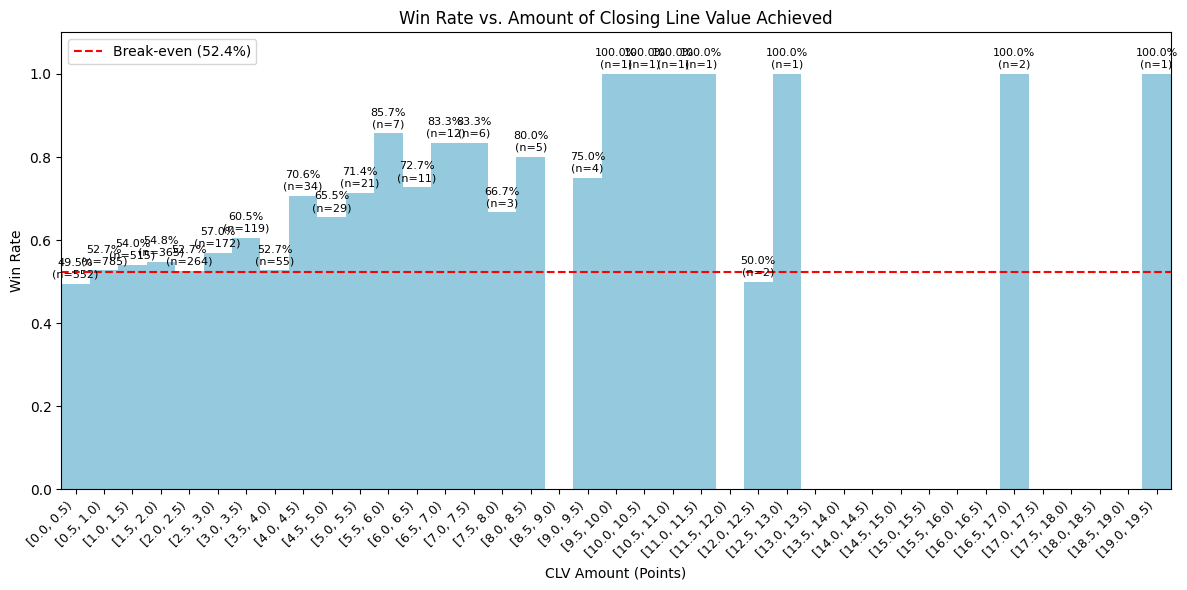

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Betting/BettingModels')

# --- Configuration ---
DB_PATH = "cfb_data.db" # Path to your SQLite database

# Betting constants (assuming -110 odds)
WIN_PAYOUT = 1.0
LOSS_AMOUNT = 1.1
PUSH_PAYOUT = 0.0

# --- Load Data ---
print(f"Connecting to database: {DB_PATH}")
conn = sqlite3.connect(DB_PATH)

# Select only necessary columns
query = """
SELECT
    id,
    season,
    week,
    home_team,
    away_team,
    home_points,
    away_points,
    avg_opening_spread,
    avg_closing_spread
FROM
    games_full
WHERE
    completed = 1;
"""
print("Loading necessary game data...")
df = pd.read_sql_query(query, conn)
conn.close()
print(f"Loaded {len(df)} completed games.")

# --- Data Preprocessing ---
# Convert scores and spreads to numeric, coercing errors
numeric_cols = ['home_points', 'away_points', 'avg_opening_spread', 'avg_closing_spread']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows where essential data is missing for this analysis
required_cols = ['home_points', 'away_points', 'avg_opening_spread', 'avg_closing_spread']
initial_rows = len(df)
df.dropna(subset=required_cols, inplace=True)
rows_dropped = initial_rows - len(df)
print(f"Dropped {rows_dropped} rows missing scores or opening/closing spreads.")
print(f"Analyzing {len(df)} games with complete data.")

if df.empty:
    print("No data available for analysis after filtering. Exiting.")
    exit()

# --- CLV Calculation and Bet Simulation ---

print("Determining CLV direction and simulating bets...")

# Calculate actual margin from away team perspective
df['actual_margin'] = df['away_points'] - df['home_points']

# Calculate Closing Line Value (CLV)
# Positive CLV for away bettor if closing spread > opening spread
# Positive CLV for home bettor if closing spread < opening spread
# Define CLV relative to the opening line number itself
# CLV if you bet AWAY = closing_spread - opening_spread
# CLV if you bet HOME = opening_spread - closing_spread (or negative of away CLV)
df['clv_amount_away_bet'] = df['avg_closing_spread'] - df['avg_opening_spread']

# Determine which side achieved positive CLV
df['bet_on_clv'] = np.select(
    [
        df['clv_amount_away_bet'] > 0,  # Positive CLV betting away line movement favoured away
        df['clv_amount_away_bet'] < 0   # Negative CLV betting away -> Positive CLV betting home
    ],
    [
        'away', # Bet away if CLV > 0 for away bet
        'home'  # Bet home if CLV < 0 for away bet (means line moved towards home)
    ],
    default=None # No bet if CLV is exactly 0
)

# Filter out games with no CLV
clv_bets_df = df[df['bet_on_clv'].notna()].copy()
num_clv_opportunities = len(clv_bets_df)

if num_clv_opportunities == 0:
    print("No games found where opening spread != closing spread. Cannot analyze CLV bets.")
    exit()

print(f"Found {num_clv_opportunities} games with non-zero CLV to simulate.")

# Grade the simulated CLV bet against the OPENING line
results = []
for index, row in clv_bets_df.iterrows():
    bet_on = row['bet_on_clv']
    opening_spread = row['avg_opening_spread']
    actual_margin = row['actual_margin'] # Away perspective
    clv = row['clv_amount_away_bet'] if bet_on == 'away' else -row['clv_amount_away_bet'] # Actual CLV achieved

    result = None
    profit_loss = 0.0

    if bet_on == 'away':
        if actual_margin > opening_spread: result, profit_loss = 'win', WIN_PAYOUT
        elif actual_margin < opening_spread: result, profit_loss = 'loss', -LOSS_AMOUNT
        else: result, profit_loss = 'push', PUSH_PAYOUT
    elif bet_on == 'home':
        if actual_margin < opening_spread: result, profit_loss = 'win', WIN_PAYOUT
        elif actual_margin > opening_spread: result, profit_loss = 'loss', -LOSS_AMOUNT
        else: result, profit_loss = 'push', PUSH_PAYOUT

    results.append({
        'game_id': row['id'],
        'season': row['season'],
        'bet_on_clv': bet_on,
        'clv_amount': clv,
        'opening_spread': opening_spread,
        'closing_spread': row['avg_closing_spread'],
        'actual_margin': actual_margin,
        'result': result,
        'profit_loss': profit_loss
    })

clv_results_df = pd.DataFrame(results)

# --- Aggregate Results ---
print("\n--- CLV Betting Simulation Results ---")

total_bets = len(clv_results_df)
total_wins = len(clv_results_df[clv_results_df['result'] == 'win'])
total_losses = len(clv_results_df[clv_results_df['result'] == 'loss'])
total_pushes = len(clv_results_df[clv_results_df['result'] == 'push'])
total_units = clv_results_df['profit_loss'].sum()

print(f"Total CLV Bets Placed: {total_bets}")
if total_bets > 0:
    win_rate = total_wins / (total_wins + total_losses) if (total_wins + total_losses) > 0 else 0
    total_risked = (total_wins + total_losses) * LOSS_AMOUNT
    roi = (total_units / total_risked) * 100 if total_risked > 0 else 0

    print(f"  Wins:           {total_wins}")
    print(f"  Losses:         {total_losses}")
    print(f"  Pushes:         {total_pushes}")
    print(f"  Win Rate:       {win_rate:.2%}")
    print(f"  Total Units:    {total_units:+.2f}")
    print(f"  Implied ROI:    {roi:.2f}%")
else:
    print("No CLV bets were placed.")

# --- Optional: Analyze Win Rate vs. CLV Amount ---
print("\n--- Win Rate vs. CLV Amount ---")
# Create bins for CLV amounts (e.g., 0.5 point increments)
bins = pd.cut(clv_results_df['clv_amount'], bins=np.arange(0, clv_results_df['clv_amount'].max() + 0.5, 0.5), right=False)
clv_binned = clv_results_df.groupby(bins).agg(
    total_bets=('result', lambda x: (x != 'push').sum()), # Count only wins/losses for win rate
    wins=('result', lambda x: (x == 'win').sum())
).reset_index()

clv_binned = clv_binned[clv_binned['total_bets'] > 0] # Keep bins with actual bets
clv_binned['win_rate'] = clv_binned['wins'] / clv_binned['total_bets']
clv_binned['clv_bin_mid'] = clv_binned['clv_amount'].apply(lambda x: x.mid) # Get midpoint for plotting

print("Win Rate per CLV Bin:")
print(clv_binned[['clv_amount', 'total_bets', 'wins', 'win_rate']].to_string(index=False, float_format="{:.2f}".format))

# Plotting
if not clv_binned.empty:
    plt.figure(figsize=(12, 6))
    sns.barplot(x='clv_amount', y='win_rate', data=clv_binned, color='skyblue', width=1)
    # Add text labels for win rate and number of bets
    for index, row in clv_binned.iterrows():
      plt.text(index, row['win_rate'] + 0.01, f"{row['win_rate']:.1%}\n(n={row['total_bets']})",
               color = 'black', ha = 'center', va = 'bottom', fontsize=8)

    plt.axhline(0.524, color='r', linestyle='--', label='Break-even (52.4%)') # Break-even for -110
    plt.xlabel('CLV Amount (Points)')
    plt.ylabel('Win Rate')
    plt.title('Win Rate vs. Amount of Closing Line Value Achieved')
    plt.xticks(rotation=45, ha='right', fontsize=9)
    plt.ylim(0, clv_binned['win_rate'].max() * 1.1 if clv_binned['win_rate'].max() > 0 else 1.0) # Dynamic ylim
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Not enough data points or bins to plot Win Rate vs. CLV Amount.")